In [15]:
import gym
import torch
from torch import nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import pyglet
from itertools import count
import math
import random
from PIL import Image
from torch.distributions import Categorical
from gym import ObservationWrapper
from gym import ActionWrapper
import os

In [16]:
os.environ["CUDA_VISIBLE_DEVICES"] = "1"

In [17]:
class policynet(nn.Module):
    def __init__(self, s_d, a_d, hidden_d):
        super(policynet, self).__init__()
        self.fc1 = nn.Sequential(
            nn.Linear(s_d, hidden_d),
            nn.ReLU(),
            nn.Linear(hidden_d, a_d)
        )
    
    def forward(self, x):
        x = self.fc1(x)
        return F.softmax(x, dim = -1)
    
class valuenet(torch.nn.Module):
    def __init__(self, s_d, hidden_d):
        super(valuenet, self).__init__()
        self.fc1 = nn.Sequential(
            nn.Linear(s_d, hidden_d),
            nn.ReLU(),
            nn.Linear(hidden_d, 1)
        )
            
    def forward(self, x):
        x = self.fc1(x)
        return x

In [24]:
env = gym.make("CartPole-v0")
env.seed(0)
torch.manual_seed(0)

s_d = env.observation_space.shape[0]
a_d = env.action_space.n
hidden_d = 128
gamma = 0.95
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
a_lr = 1e-3
c_lr = 1e-2
num_episodes = 1000

batchsize=10
num_batch = int(num_episodes/batchsize)

In [25]:
class a2c:
    def __init__(self, s_d, a_d, gamma, hidden_d, a_lr, c_lr, device):
        self.actor = policynet(s_d, a_d, hidden_d).to(device)
        self.critic = valuenet(s_d, hidden_d).to(device)
        self.actor_optim = torch.optim.Adam(self.actor.parameters(), lr = a_lr)
        self.critic_optim = torch.optim.Adam(self.critic.parameters(), lr = c_lr)
        self.gamma = gamma
    
    def act(self, s):
        s_input = torch.tensor([s], dtype = torch.float).to(device)
        a = Categorical(self.actor(s_input)).sample().item()
        return a
    
    def l2t(self, List):  # list-to-tensor function, delete the last entry
        if len(List) > 0:
            return torch.tensor(List[0:-1], dtype = torch.float)

    def upd(self, traj):
        s_tensor = torch.tensor(traj['s']).to(device)
        a_tensor = torch.tensor(traj['a']).view(-1,1).to(device)
        s__tensor = torch.tensor(traj['s_']).to(device)
        r_tensor = torch.tensor(traj['r']).view(-1,1).to(device)
        dones_tensor = torch.tensor(traj['dones'],dtype = torch.float).view(-1,1).to(device)
        
        td_stp1 = r_tensor + self.gamma * (1 - dones_tensor) * self.critic(s__tensor)
        td_err = td_stp1 - self.critic(s_tensor)
        a_loss = -torch.mean(torch.log(self.actor(s_tensor)).gather(1,a_tensor) * td_err.detach())
        c_loss = F.mse_loss(td_stp1.detach(), self.critic(s_tensor))
        self.actor_optim.zero_grad()
        self.critic_optim.zero_grad()
        a_loss.backward()
        c_loss.backward()
        self.actor_optim.step()
        self.critic_optim.step()        

In [26]:
agent = a2c(s_d, a_d, gamma, hidden_d, a_lr, c_lr, device)

In [27]:
return_list = []
for i in range(num_batch):
    with tqdm(total=batchsize, desc='Iter %d' % i) as pbar:
        for i_episode in range(batchsize):
            total_return = 0
            traj = {'s': [], 'a': [], 's_': [], 'r': [], 'dones': []}
            s = env.reset()
            done = False
            while not done:
                # print(s)
                a = int(agent.act(s))
                s_, r, done, _ = env.step(a)
                traj['s'].append(s)
                traj['a'].append(a)
                traj['s_'].append(s_)
                traj['r'].append(r)
                traj['dones'].append(done)
                s = s_
                total_return = total_return + r
            return_list.append(total_return)
            agent.upd(traj)

            if (i_episode+1) % 5 == 0:
                pbar.set_postfix({'epis': '%d' % (5 * i + i_episode+1), 'mean return': '%.3f' % np.mean(return_list[-5:])})
            pbar.update(1)

Iter 99: 100%|██████████| 10/10 [00:01<00:00,  8.82it/s, epis=505, mean return=200.000]


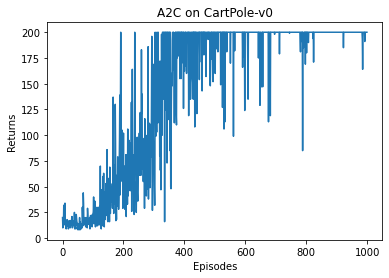

In [28]:
episodes_list = list(range(len(return_list)))
plt.plot(episodes_list,return_list)
plt.xlabel('Episodes')
plt.ylabel('Returns')
plt.title('A2C on {}'.format("CartPole-v0"))
plt.show()